In [1]:
# matlab like environment, otherwise use import control
import control
from control.matlab import *
import numpy as np
from numpy import array as v

consider the system 

$$dx + -x + u$$

$$y = x$$


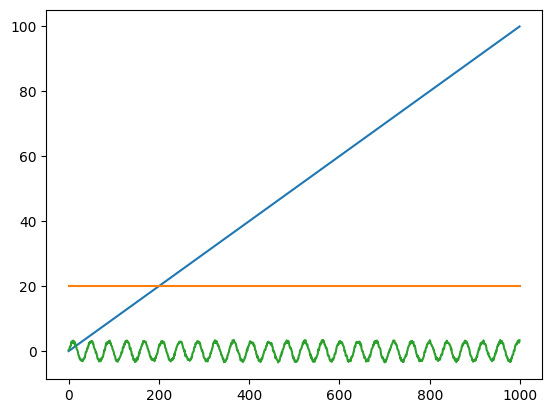

In [2]:
# general inputs/setpoints
import math
import matplotlib.pyplot as plt

time = v([t for t in np.linspace(0,100,1000)])
setpoints = np.zeros_like(time) + 20
disturbance = v([ 3*math.sin(i/2/math.pi) + np.random.rand() - 0.5 for i in range(time.shape[0]) ])

plt.plot(time)
plt.plot(setpoints)
plt.plot(disturbance)


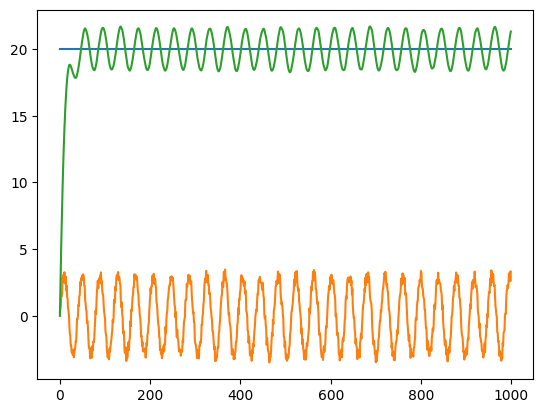

In [3]:
# open loop

# extended system with disturbance
A_ol = v([[-1, 0],[0, 0]])
B_ol = v([[1, 1], [0, 0]])
C_ol = v([1, 0])
D_ol = v([0, 0])

ol = ss(A_ol, B_ol, C_ol, D_ol)

dyn_ol = control.forced_response(ol, T=time, U=np.stack([setpoints, disturbance]))

plt.plot(setpoints)
plt.plot(disturbance)
plt.plot(dyn_ol.states[0])

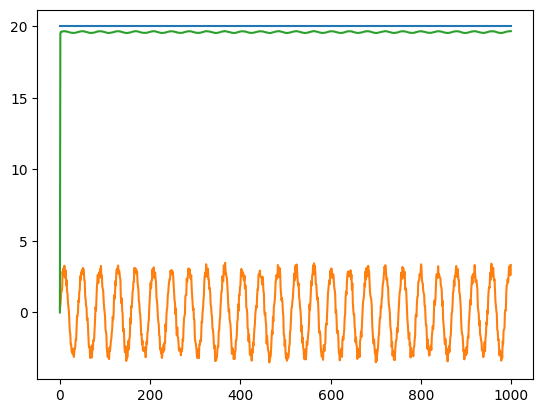

In [4]:
# P control

# closed loop (P)

Kp = 50

# extended system with disturbance
A_P = v([[-(1 + Kp)]])
B_P = v([[Kp, 1]])
C_P = v([1])
D_P = v([0, 0])

P = ss(A_P, B_P, C_P, D_P)

dyn_P = control.forced_response(P, T=time, U=np.stack([setpoints, disturbance]))

plt.plot(setpoints)
plt.plot(disturbance)
plt.plot(dyn_P.states[0])


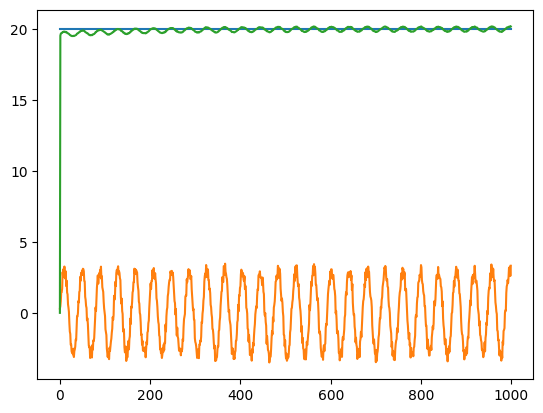

In [5]:
# PI control

# closed loop (PI)

Kp = 50
Ki = 3

# extended system with disturbance X = (x,z) U = (r, d)
A_PI = v([[-(1 + Kp), Ki], [-1, 0]])
B_PI = v([[Kp, Ki], [1, 0]])
C_PI = v([1, 0])
D_PI = v([0, 0])

PI = ss(A_PI, B_PI, C_PI, D_PI)

dyn_PI = control.forced_response(PI, T=time, U=np.stack([setpoints, disturbance]))

plt.plot(setpoints)
plt.plot(disturbance)
plt.plot(dyn_PI.states[0])

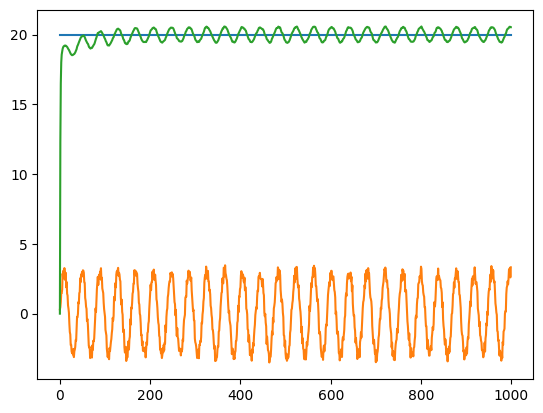

In [6]:
# PI control with knowledge on the road # TODO

# closed loop (PI)

Kp = 10
Ki = 2

# extended system with disturbance X = (x,z) U = (r, d, t)
A_PI = v([[-(1 + Kp), Ki], [-1, 0]])
B_PI = v([[Kp, Ki, ], [1, 0]])
C_PI = v([1, 0])
D_PI = v([0, 0])

PI = ss(A_PI, B_PI, C_PI, D_PI)

dyn_PI = control.forced_response(PI, T=time, U=np.stack([setpoints, disturbance]))
#dyn_PI = control.forced_response(PI, T=time, U=np.stack([setpoints, np.zeros_like(setpoints)]))

plt.plot(setpoints)
plt.plot(disturbance)
plt.plot(dyn_PI.states[0])

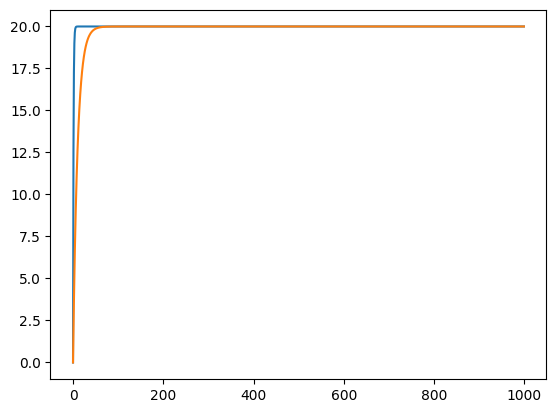

In [7]:
# linear bandwidth control

w_b = 10 # bandwith for 0bd crossing

lbc = ss(-1,1,1,0) # no disturbances
tf_lbc = ss2tf(lbc)

# make this compatible with tr. fun.
s = tf('s')
K = w_b/s/tf_lbc

tf_loop_lbc = feedback(K*tf_lbc, 1)

dyn_LBC = control.forced_response(tf_loop_lbc, T=time, U=np.stack([setpoints]))
dyn_LBC_ol = control.forced_response(lbc, T=time, U=np.stack([setpoints]))

#plt.plot(step(tf_loop_lbc)[1], step(tf_loop_lbc)[0])
#plt.plot(step(tf_lbc)[1],step(tf_lbc)[0])

plt.plot(dyn_LBC[1])
plt.plot(dyn_LBC_ol[1])


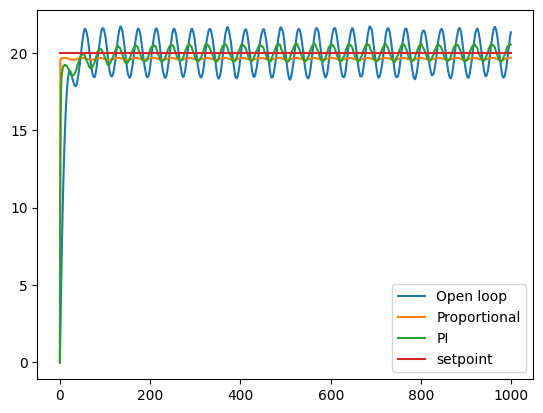

In [8]:
plt.plot(dyn_ol.states[0])
plt.plot(dyn_P.states[0])
plt.plot(dyn_PI.states[0])
plt.plot(setpoints)
plt.legend(['Open loop', 'Proportional', 'PI', 'setpoint'])

## Balanced Truncation Example

[[-1.28659577  1.28659577]
 [ 0.38862245  0.38862245]]


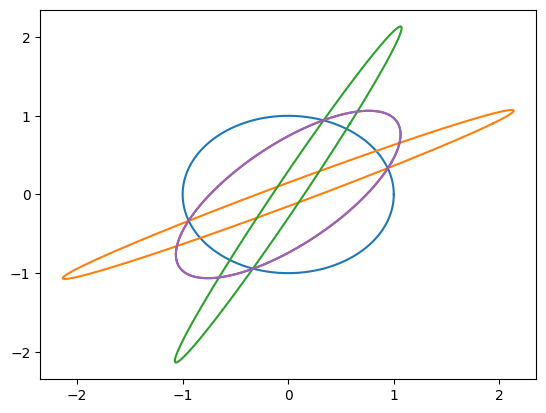

In [9]:
import slycot
# let's start with a simple system

A = [[-0.75, 1],[-0.3, -0.75]]
B = [[2], [1]]
C = [[1, 2], [0, 0]]
D = [[0], [0]]

sys_full = ss(A,B,C,D)

Wc = gram(sys_full, 'c')
Wo = gram(sys_full, 'o')

### plotting the circonference and elipsoids
theta = np.linspace(0,2*math.pi, 1000)
xc = np.cos(theta)
yc = np.sin(theta)
CIRC = [xc, yc]
ELLIPc = np.sqrt(Wc) * (CIRC)
ELLIPo = np.sqrt(Wo) * (CIRC)

plt.plot(xc, yc)
plt.plot(np.array(ELLIPc)[0], np.array(ELLIPc)[1])
plt.plot(np.array(ELLIPo)[0], np.array(ELLIPo)[1])

# computing the BT

# create a new system based on T-unbalanced (a partial transformation)

Tval, T = np.linalg.eig(Wc*Wo)

A_hat = np.linalg.inv(T)*A*T
B_hat = np.linalg.inv(T)*B
C_hat = C*T

sys_rotated = ss(A_hat, B_hat, C_hat, D)

# compute sigmas

Sc = gram(sys_rotated, 'c')
So = gram(sys_rotated, 'o')

Ss = (np.diag(Sc)**(1/4)) * (np.diag(So)**(-1/4))
T = T*np.array([[Ss[0], 0], [0,Ss[1]]])

# sort the eigenvectors

T.sort(axis=1)

# recompute new system based on T-balanced (the true transformation)

A_hat = np.linalg.inv(T)*A*T
B_hat = np.linalg.inv(T)*B
C_hat = C*T

sys_rotated = ss(A_hat, B_hat, C_hat, D)

# recompute gramiens

Wc_BT = gram(sys_rotated, 'c')
Wo_BT = gram(sys_rotated, 'o')

ELLIPc_BT = np.linalg.inv(T)*np.sqrt(Wc_BT.round(10))*T * (CIRC)
plt.plot(np.array(ELLIPc_BT)[0], np.array(ELLIPc_BT)[1])

ELLIPo_BT = np.linalg.inv(T)*np.sqrt(Wo_BT.round(10))*T * (CIRC) # sqrt from ellipse
plt.plot(np.array(ELLIPo_BT)[0], np.array(ELLIPo_BT)[1])

print(T)

[[-1.28659577  1.28659577]
 [ 0.38862245  0.38862245]]


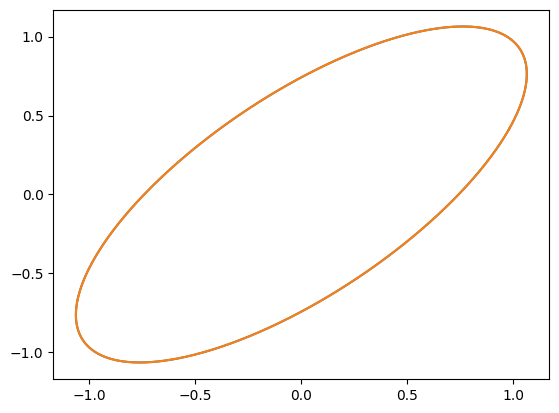

In [10]:
# compact method for computing T

Tval, T = np.linalg.eig(Wc*Wo)

Sc = np.linalg.inv(T)*Wc*np.linalg.inv(T.T)
So = T.T*Wo*T

Ss = (np.diag(Sc)**(1/4)) * (np.diag(So)**(-1/4))
T = T*np.array([[Ss[0], 0], [0,Ss[1]]])

T.sort(axis=1)

#
# just showing that it produces the same result
#

A_hat = np.linalg.inv(T)*A*T
B_hat = np.linalg.inv(T)*B
C_hat = C*T

sys_rotated = ss(A_hat, B_hat, C_hat, D)

# recompute gramiens

Wc_BT = gram(sys_rotated, 'c')
Wo_BT = gram(sys_rotated, 'o')

ELLIPc_BT = np.linalg.inv(T)*np.sqrt(Wc_BT.round(10))*T * (CIRC)
plt.plot(np.array(ELLIPc_BT)[0], np.array(ELLIPc_BT)[1])

ELLIPo_BT = np.linalg.inv(T)*np.sqrt(Wo_BT.round(10))*T * (CIRC) # sqrt from ellipse
plt.plot(np.array(ELLIPo_BT)[0], np.array(ELLIPo_BT)[1])

print(T)

### Balreal porting (from matlab)

[[-1.28659577  1.28659577]
 [ 0.38862245  0.38862245]]


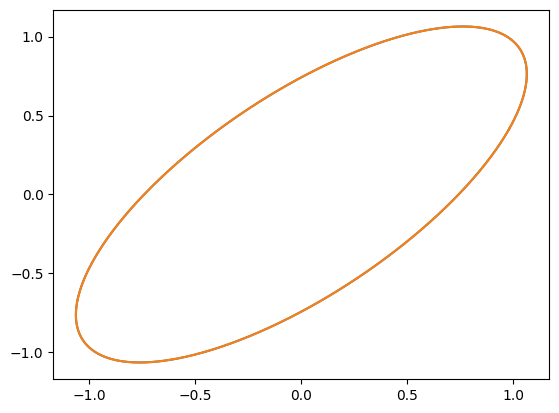

In [11]:
def balreal(system):

    Wc = gram(system, 'c')
    Wo = gram(system, 'o')

    Tu = np.linalg.eig(Wc*Wo)[1]
    
    Sc = np.linalg.inv(Tu)*Wc*np.linalg.inv(Tu.T)
    So = Tu.T*Wo*Tu
    Ss = np.diag((np.diag(Sc)/np.diag(So))**(1/4)) # sigma
    T = Tu*Ss 
    T.sort(axis=1) # transformation 

    A_hat = np.linalg.inv(T)*system.A*T
    B_hat = np.linalg.inv(T)*system.B
    C_hat = system.C*T
    D_hat = system.D

    sys_rotated = ss(A_hat, B_hat, C_hat, D_hat) # new system

    return [sys_rotated, np.diag(Ss), T, np.linalg.inv(T)]

    
sys, sigma, T, Ti = balreal(sys_full)

print(T)

## PLOTTING example

Wc_BT = gram(sys, 'c')
Wo_BT = gram(sys, 'o')

ELLIPc_BT = np.linalg.inv(T)*np.sqrt(Wc_BT.round(10))*T * (CIRC)
plt.plot(np.array(ELLIPc_BT)[0], np.array(ELLIPc_BT)[1])

ELLIPo_BT = np.linalg.inv(T)*np.sqrt(Wo_BT.round(10))*T * (CIRC) # sqrt from ellipse
plt.plot(np.array(ELLIPo_BT)[0], np.array(ELLIPo_BT)[1])


## BPOD: Balanced proper orthogonal decomposition

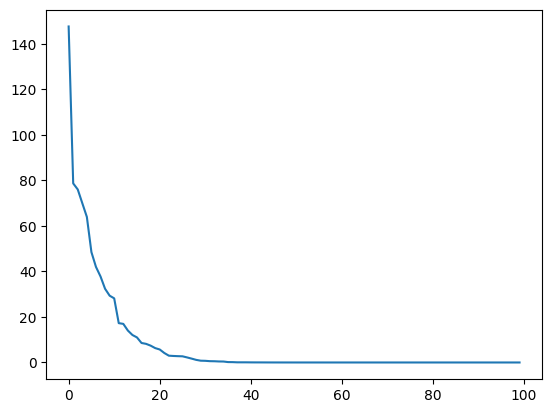

In [184]:
q = 2   # inputs
p = 2   # outputs
n = 100 # states
sysFull_cont = rss(n,p,q) # random sys (discrete)
dt = 0.001
sysFull = c2d(sysFull_cont, dt) # random sys (discrete)
r = 10  # reduced model order

plt.plot(hsvd(sysFull_cont)) # plot Hankel SVD to see how much is retained in a r reduction

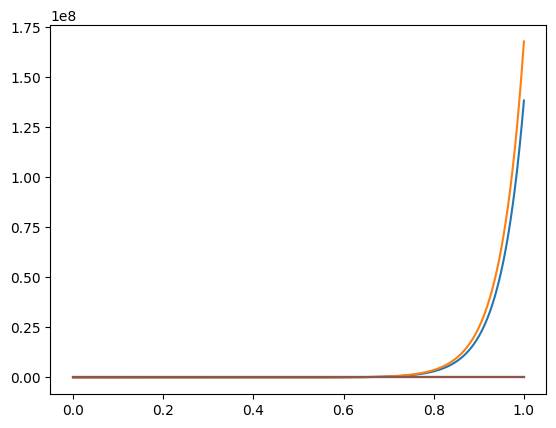

In [186]:
# compute the direct and adjoint impulse responses
yFull, tFull = impulse(sysFull, np.linspace(0,1, (int(1/dt))+1))
sysAdj = ss(sysFull.A.T, sysFull.C.T, sysFull.B.T, sysFull.D.T)
yAdj, tAdj = impulse(sysAdj, np.linspace(0,1, (int(1/dt))+1))

# compute OC (Hankel matrix)
Ct = ctrb(sysFull.A, sysFull.B)                    
Os = obsv(sysFull.A, sysFull.C)                    
H = Os*Ct                                          
u,s,vh = np.linalg.svd(H)                         
psi = Ct*vh[:,0:r]*np.sqrt(np.diag(s[0:r]))    
phi = Os.T*u[:,0:r]*np.sqrt(np.diag(s[0:r]))     

# compute the reduced system using the formulas

#sysBPOD = ss(phi.T*sysFull.A*psi, phi.T*sysFull.B, sysFull.C*psi, sysFull.D) 
sysBPOD = ss(phi.T*sysFull.A*psi, phi.T*sysFull.B, sysFull.C*psi, sysFull.D)


# compare impulse responses of the different methods

yBPOD, tBPOD = impulse(sysBPOD, np.linspace(0,1, (int(1/dt))+1))
sysBT = balred(sysFull_cont, r)
yBT, tBT = impulse(sysBT, np.linspace(0,1, (int(1/dt))+1))

plt.plot(tBPOD, [x[0] for x in yBPOD])
plt.plot(tBPOD, [x[1] for x in yBPOD])
plt.plot(tBT, [x[0] for x in yBT])
plt.plot(tBT, [x[1] for x in yBT])
plt.plot(tFull, [x[0] for x in yFull])
plt.plot(tFull, [x[1] for x in yFull])

In [152]:
print(ss2tf(sysBPOD))


Input 1 to output 1:
   1847 s + 1.893e+04
------------------------
s^2 - 6437 s + 1.254e+06

Input 1 to output 2:
    -337.2 s - 9571
------------------------
s^2 - 6437 s + 1.254e+06

Input 2 to output 1:
  -86.23 s - 1.584e+04
------------------------
s^2 - 6437 s + 1.254e+06

Input 2 to output 2:
     15.7 s + 3419
------------------------
s^2 - 6437 s + 1.254e+06

